In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFont
import json
import random

import clip
import os
from tqdm import tqdm
from cj_fonts import inclusive_fonts, fifty_fonts
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomCrop, RandomRotation, RandomResizedCrop
from torchvision.transforms import Lambda
from torchvision.transforms import functional as F
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.font_manager import FontProperties
import PIL

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
%matplotlib inline

from utils.init_model import load_model, my_preprocess
from utils.initialize_font_data import retrieve_font_path, exclusive_attributes, inclusive_attributes
from dataset.dataset import MyDataset, TestDataset
from evals.evaluate_tools import evaluate_used_dumped_image_use_score, evaluate_use_dumped_image, calculate_corr, generate_all_attribute_embedded_prompts
from utils.transform_image import draw_text_with_new_lines, generate_all_fonts_embedded_images

# If using GPU then use mixed precision training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Must set jit=False for training
model_name = "ViT-B/32"
# model_name = "ViT-L/14"
model, preprocess = clip.load(model_name, device=device, jit=False)
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
exclusive_attributes:  []
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
font_dir = '../gwfonts'
cj_font_dir = '../all-fonts'
char_size = 150
fifty_font_paths = [os.path.join(cj_font_dir, f) for f in fifty_fonts.split('\n') if f != '']

# add font
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

for font in font_manager.findSystemFonts(cj_font_dir):
    font_manager.fontManager.addfont(font)

ttf_list = font_manager.fontManager.ttflist

all_json_path = '../attributeData/all_font_to_attribute_values.json'
train_json_path = '../attributeData/train_font_to_attribute_values_5.json'
test_json_path = '../attributeData/test_font_to_attribute_values_5.json'
validation_json_path = '../attributeData/validation_font_to_attribute_values_5.json'
all_json = json.load(open(all_json_path, 'r'))
train_json = json.load(open(train_json_path, 'r'))
test_json = json.load(open(test_json_path, 'r'))
validation_json = json.load(open(validation_json_path, 'r'))
train_font_names = list(train_json.keys())
test_font_names = list(test_json.keys())
validation_font_names = list(validation_json.keys())

font_names = list(all_json.keys())
font_paths = [retrieve_font_path(font_name, font_dir=font_dir) for font_name in font_names]

fox_text = 'The quick\nbrown fox\njumps over\nthe lazy dog'
colors = ['red', 'blue', 'green', 'orange', 'purple']

In [3]:
train_font_num = len(list(json.load(open(train_json_path, 'r')).keys()))
print(train_font_num)

validation_font_num = len(list(json.load(open(validation_json_path, 'r')).keys()))
print(validation_font_num)

test_font_num = len(list(json.load(open(test_json_path, 'r')).keys()))
print(test_font_num)

120
40
40


In [4]:
def calculate_tsne_vectors(checkpoint_paths, image_file_dir='../attributeData/grayscale_images/', text=fox_text, model=model, perplexity=30):
  tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
  embedded_images = None
  for checkpoint_path in checkpoint_paths:
    model = load_model(model, checkpoint_path)
    tmp_embedded_images = generate_all_fonts_embedded_images(font_paths, text, model=model, preprocess=preprocess, image_file_dir=image_file_dir)
    tmp_embedded_images = torch.cat(list(tmp_embedded_images.values()), dim=0)
    # tmp_embedded_prompts = generate_all_attribute_embedded_prompts(inclusive_attributes, model=model)
    # embedded_prompts = torch.cat(list(tmp_embedded_prompts.values()), dim=0)
    if embedded_images is None:
      embedded_images = tmp_embedded_images
    else:
      embedded_images = torch.cat((embedded_images, tmp_embedded_images), dim=0)
  tsne_vectors = tsne.fit_transform(embedded_images.cpu().detach().numpy())
  return tsne_vectors

def show_map(vectors, checkpoint_path_num, font_paths, annotation_text='A', figsize=(15, 15), colors = ['red', 'blue', 'green', 'orange', 'purple'], save_file_path=None, show_legend=True):
  assert len(vectors) == checkpoint_path_num * len(font_paths)
  my_font = FontProperties()
  fig, ax = plt.subplots(figsize=figsize)

  for i in range(checkpoint_path_num):
    assert i < len(colors)
    for j in range(len(font_paths)):
        font_path = font_paths[j]
        my_font.set_file(font_path)
        tmp_index = i * len(font_path) + j
        ax.scatter(vectors[tmp_index, 0], vectors[tmp_index, 1], marker='o', color=colors[i], alpha=0)
        ax.annotate(annotation_text, (vectors[tmp_index, 0], vectors[tmp_index, 1]), fontsize=35, fontproperties=my_font, color=colors[i])

  plt.axis('off')
  if show_legend:
    red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='FontCLIP')
    blue_square = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, label='FontCLIP-Contrastive')
    ax.legend(handles=[red_square, blue_square], loc='lower left', prop = { "size": 20 })
    # ax.legend(loc='lower left')
  if save_file_path is not None:
    plt.savefig(save_file_path)
  plt.show()

In [5]:

fox_text = 'The quick\nbrown fox\njumps over\nthe lazy dog'
#fox_text = 'The quick brown\nfox jumps over\nthe lazy dog'
#fox_text = 'A'
alphabet_text = 'ABCD\nEFGH\nIJKL\nMNOP\nQRST\nUVWX\nYZ'
#fox_text = 'abcdefg\nhijklmn\nopqrstu\nvwxyz'
#fox_text = 'ABCD\nEFGH\nIJKL'
#fox_text = 'k'
texts_for_font_image = [fox_text]

target_attributes = ['happy']

image_file_dir = None
image_file_dir = '../attributeData/grayscale_images'
dump_image = True
single_character = False
use_score = True
dataset = MyDataset(font_dir, train_json_path, texts_for_font_image, char_size=150, attribute_threshold=50, use_negative=True, use_weight=False, preprocess=preprocess, use_multiple_attributes=False, use_random_attributes=False, max_sample_num=3, random_prompts_num=100, exclusive_attributes=exclusive_attributes, image_file_dir=image_file_dir, dump_image=dump_image, single_character=single_character)
test_data = TestDataset(font_dir, validation_json_path, texts_for_font_image, char_size=150, attribute_threshold=0, target_attributes=target_attributes, preprocess=my_preprocess, single_character=single_character, image_file_dir=image_file_dir)
#set_image_tensors(dataset, sample_num=10)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)
it = iter(data_loader)
test_it = iter(test_data_loader)

In [7]:
checkpoint_paths = [
  # 'model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.0_lr2e-05-0.1_image_file_dir.pt',
  # 'model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss0.1_lr2e-05-0.1_image_file_dir.pt',
  # 'model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-06_lr2e-05-0.1_image_file_dir.pt',
  'model_checkpoints/cross_validation_5_0_ViT-B_32_unpretrained_vision_9101191011_batch64_aug250_lower_bound_of_scale0.35_use_negative_lr2e-05-0.1_image_file_dir.pt',
  'model_checkpoints/best_myfont9101191011_batch64_aug5_use_negative_loss0.0001_lr2e-05-0.1.pt',
  None,
  ]

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


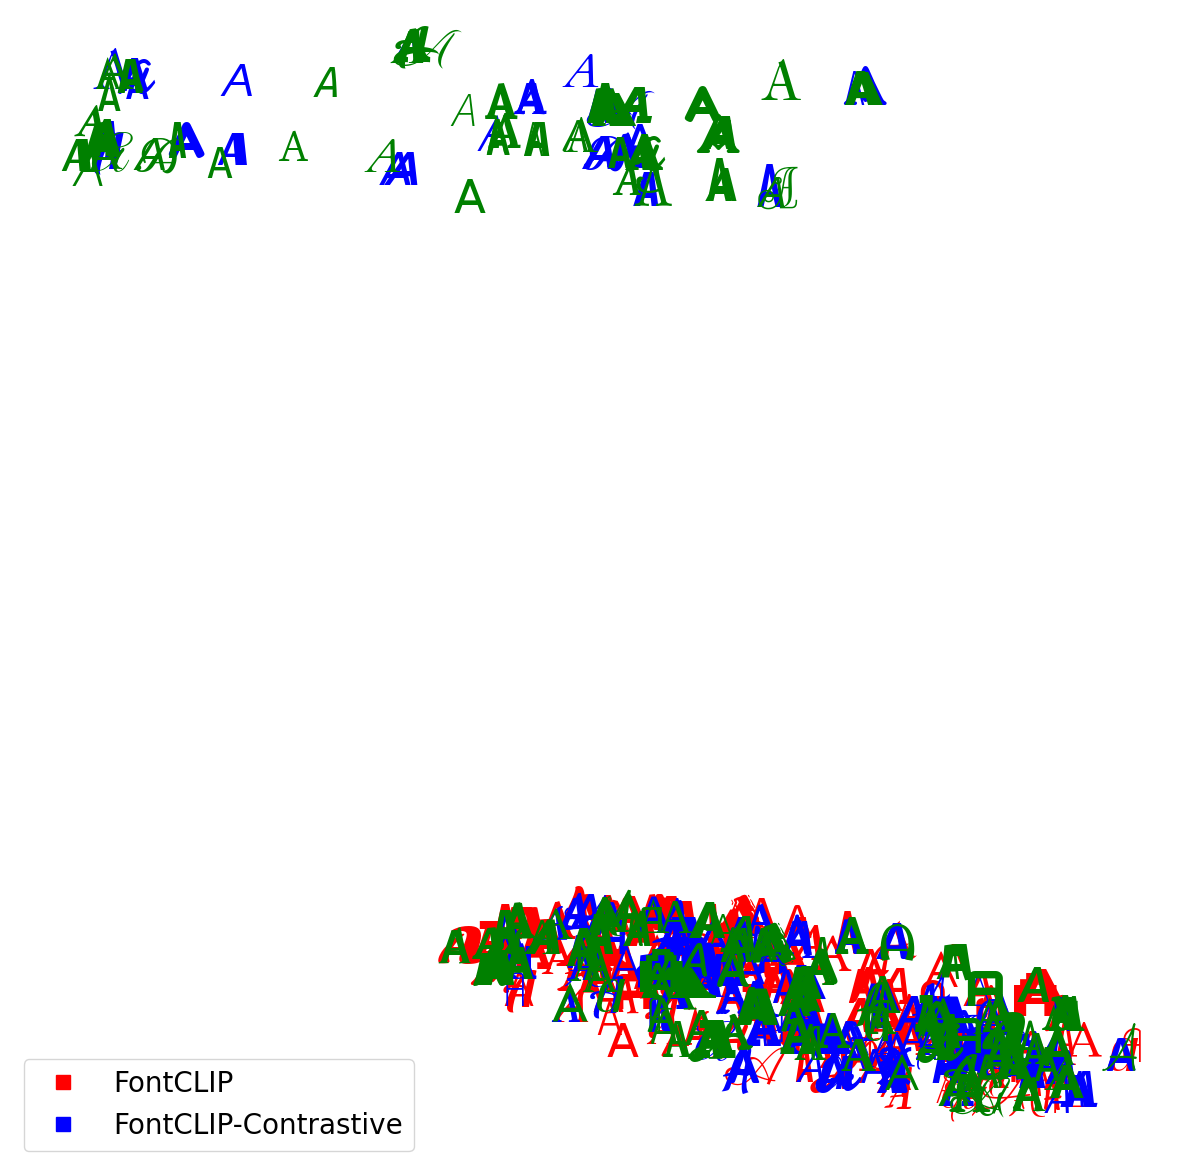

In [8]:
tmp_colors = ['red', 'blue', 'green']
save_file_path = '../attributeData/plt_outputs/comparison.svg'
tsne_vectors = calculate_tsne_vectors(checkpoint_paths, image_file_dir='../attributeData/grayscale_images/', text=fox_text, perplexity=100)
if len(checkpoint_paths) == 1:
  tmp_colors = ['black']
show_map(tsne_vectors, checkpoint_path_num=len(checkpoint_paths), font_paths=font_paths, annotation_text='A', figsize=(15, 15), colors = tmp_colors, save_file_path=save_file_path)